In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import json
import scipy.spatial.distance
import seaborn as sns
from scipy.stats import ttest_1samp
sno = nltk.stem.SnowballStemmer('english')
import sys
sys.path.append('..')
from helpers.glove_neighbors import *

In [2]:
config = json.load(open('../config.json', 'r'))
DATA_DIR = config['DATA_DIR']
TWEET_DIR = config['TWEET_DIR']
NRC_DIR = config['NRC_DIR']

# build own affect lexicon based on NRC

In [3]:
glove = pd.read_csv(DATA_DIR + 'glove.50d.csv', sep='\t', index_col=0)
vocab = set(glove.index)

In [4]:
# load NRC
nrc_lexicon = pd.read_csv(NRC_DIR + 'nrc-emotion.csv', sep='\t', index_col=0)

# stem indices
new_indices = [sno.stem(str(w).lower()) for w in nrc_lexicon.index]
nrc_lexicon.index = new_indices

# get all stems associated with a particular affect category
nrc_dict = {}
for cat in nrc_lexicon.columns:
    nrc_dict[cat] = set(nrc_lexicon[nrc_lexicon[cat] == 1].index)

In [5]:
nrc_lexicon.columns  # affect categories

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [6]:
# keep only stems that are among our GloVe embeddings (based on the joint vocab)
new_nrc = {k:[] for k in nrc_dict}
for k, words in nrc_dict.items():
    for w in words:
        if w in vocab:
            new_nrc[k].append(w)

In [10]:
# these are manually specified keywords from our vocabulary matching the affect categories
key_words = {'negative':['hatr', 'hate', 'griev', 'grief', 'wrong'], 
             'sadness':['mourn', 'sadden', 'griev', 'grief', 'sad', 'suffer', 'affect', 'broken', 'senseless', 'loss', 'heartbroken'],
            'positive':['love', 'donat', 'heart', 'thought', 'strength', 'bless', 'solidar'], 
            'anger':['deserv', 'lynch', 'gang', 'threat','mad', 'sicken', 'harm', 'enforc', 'firearm', 'ridicul', 'assault'],
            'fear':['risk',  'hide', 'danger', 'warn', 'fear'], 
            'trust':['secur', 'coach', 'safe', 'hero', 'nation'],
            'disgust':['disgust', 'disgrac', 'shame','gut', 'slaughter', 'sicken', 'sick',  'ill', 'lunat', 'coward']}

In [11]:
def cosine(u, v):
    return scipy.spatial.distance.cosine(u, v)

In [12]:
filtered_nrc = {}
for k, v in key_words.items():
    print(k)
    words = new_nrc[k]
    dists = []
    for w in words:
        dists.append(np.mean([cosine(glove.loc[w], glove.loc[word]) for word in v]))
    filtered_nrc[k] = [words[i] for i in np.array(dists).argsort()[:30]]

negative
sadness
positive
anger
fear
trust
disgust


In [13]:
for k, v in filtered_nrc.items():
    print(k + ':', ', '.join(v))
    print('----')

negative: hate, violenc, hatr, of, evil, tragedi, will, word, attack, sad, feel, anger, murder, shoot, massacr, want, need, pain, kill, griev, crime, ignor, victim, lost, grief, senseless, tragic, fear, loss, sick
----
sadness: senseless, loss, tragedi, lost, devast, sad, love, griev, horrif, terribl, pain, violenc, condol, broken, hurt, feel, victim, mourn, horrifi, will, grief, ach, suffer, sick, kill, aw, sicken, evil, massacr, mad
----
positive: love, friend, pray, thought, affect, bless, god, pleas, communiti, hope, stand, thank, help, condol, will, comfort, time, strong, work, support, effect, strength, feel, peac, word, rest, give, great, action, good
----
anger: gun, will, murder, kill, violenc, wrong, shoot, bad, death, attack, feel, shot, action, arm, idiot, crazi, crimin, terrorist, mad, hell, crime, blame, fight, ridicul, insan, shit, die, threat, terror, hate
----
fear: danger, threat, fear, arm, gun, still, shooter, attack, feel, fight, hide, murder, shot, shoot, bad, kil

In [15]:
with open(DATA_DIR + 'affect_lexicon.json', 'w') as f:
    f.write(json.dumps(filtered_nrc))

# plot affect partisanship

In [16]:
events = open(DATA_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(DATA_DIR + "shooters_race.json","r"))

In [17]:
def get_odds(features):
    dem_sum = sum([counts['dem'] for k, counts in features.items()])
    rep_sum = sum([counts['rep'] for k, counts in features.items()])
    odds = {}
    for k, counts in features.items():
        dem = counts['dem']
        rep = counts['rep']
        odds[k] =  np.log((rep / (rep_sum - rep)) / (dem / (dem_sum - dem)))
    return odds

In [18]:
event_list = []
cat_list = []
odds_list = []
race = []
for e in events:
    features = json.load(open(TWEET_DIR+e+'/'+e+'_affect_features.json', 'r'))
    odds = get_odds(features)
    for k, v in odds.items():
        event_list.append(e)
        cat_list.append(k)
        odds_list.append(v)
        race.append(shooter_race[e])

df = pd.DataFrame.from_dict({'event':event_list, 'odds':odds_list, 'category':cat_list, 'race':race})

[None, None]

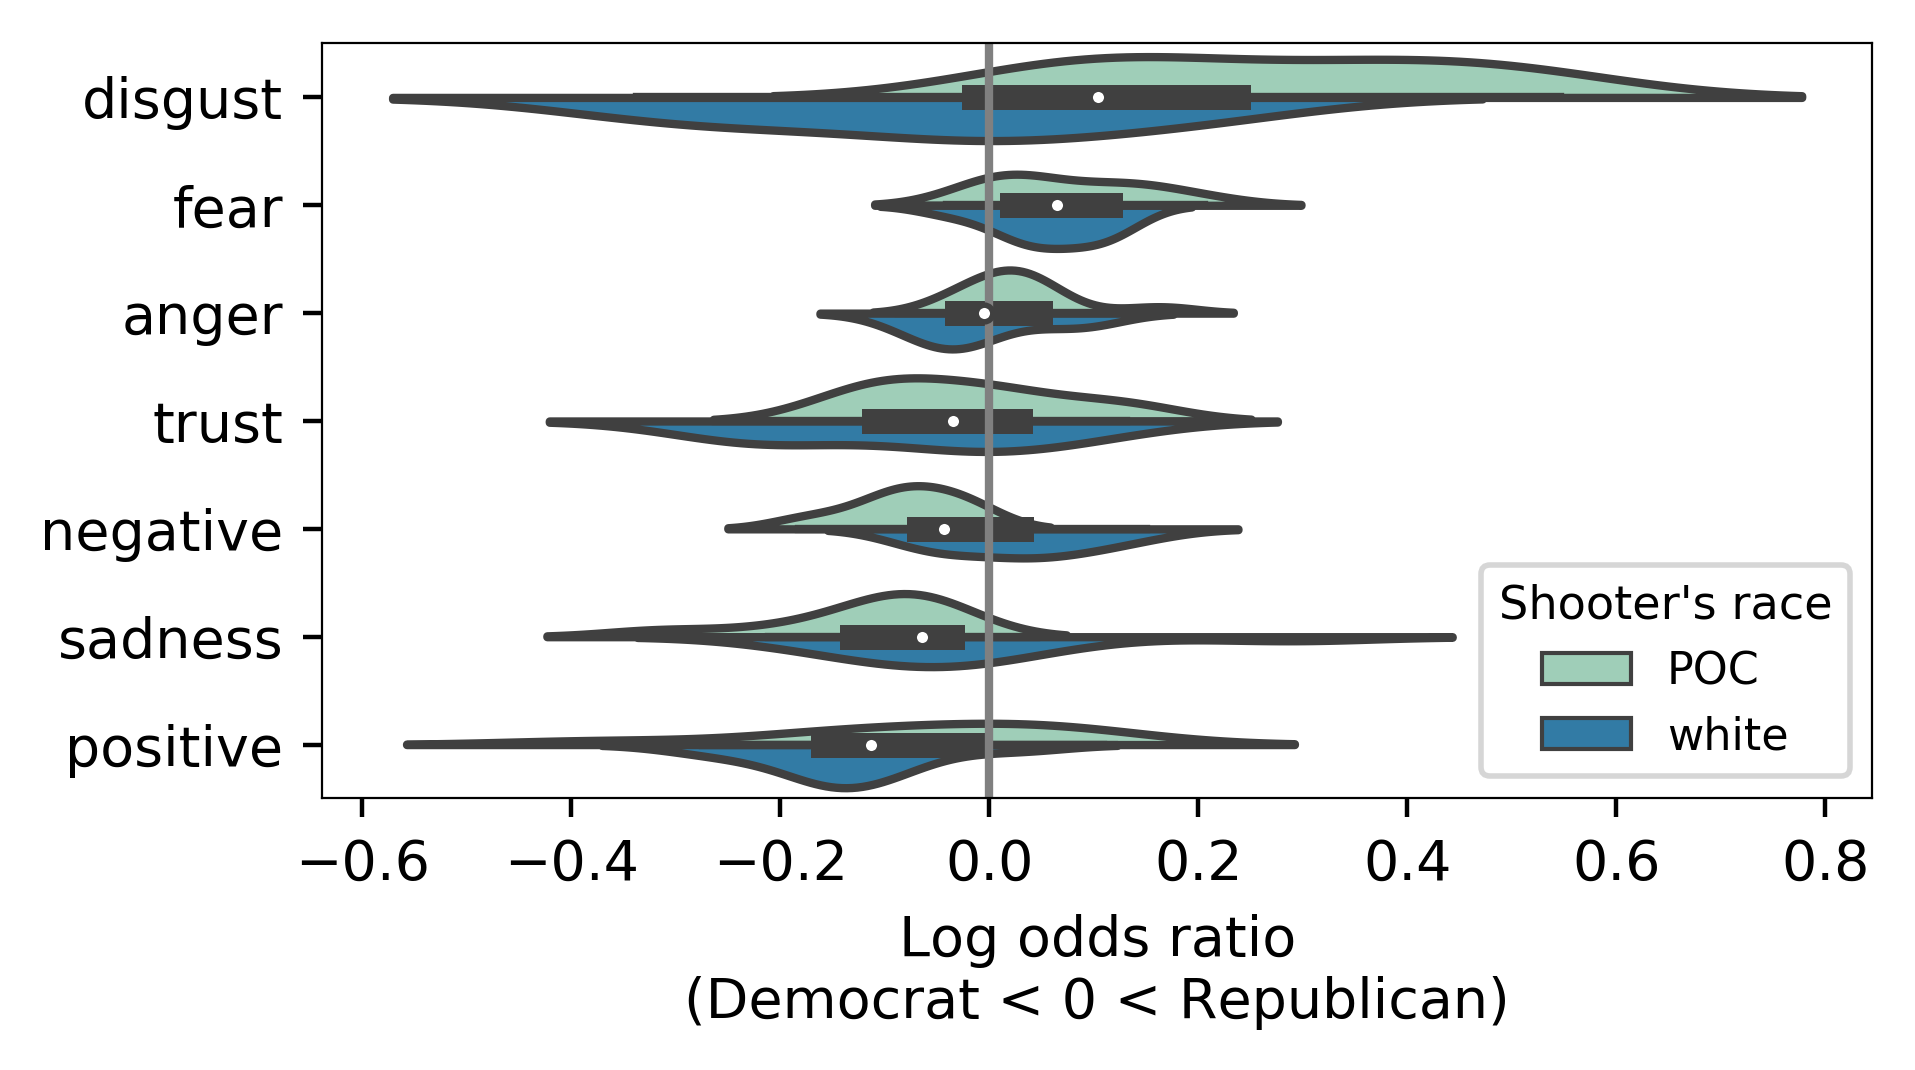

In [19]:
f = plt.figure(dpi=400, figsize=(5,2.5))
ax = sns.violinplot(data=df, x="odds",y="category", hue='race', split=True, fliersize=2, notch=True, order=reversed(df.groupby('category').median().sort_values('odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))

plt.axvline(x=0, color='grey')
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='lower right', title="Shooter's race", fontsize=8)
plt.setp(legend.get_title(),fontsize='small')

In [18]:
for i, g in df.groupby('category'):
    print(i)
    print(ttest_1samp(np.array(g['odds']), 0))

anger
Ttest_1sampResult(statistic=0.6767962749824988, pvalue=0.5062882851715453)
disgust
Ttest_1sampResult(statistic=1.0477994224763867, pvalue=0.3072291802314848)
fear
Ttest_1sampResult(statistic=4.152470829430858, pvalue=0.0004925230155515256)
negative
Ttest_1sampResult(statistic=-1.762272613526902, pvalue=0.09330092734835556)
positive
Ttest_1sampResult(statistic=-4.186292422223231, pvalue=0.0004550717807660638)
sadness
Ttest_1sampResult(statistic=-3.448393813927666, pvalue=0.0025410313292254932)
trust
Ttest_1sampResult(statistic=-0.33103164613389807, pvalue=0.7440637744842269)
